In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import odeint

%matplotlib inline

In [2]:
"""Constants"""
eps0 = 8.854e-12 #[F/m]
e = 1.60217662e-19 #elementary charge [C]
h = 6.62607004e-34 #Planck's constant [Js]
m_e = 9.10938356e-31 #electron mass [kg]

In [3]:
"""Material dependant constants:"""
'''Fluid'''
fluid_density = 0.164 #helium
eta = 3.12e-5 #shear viscosity = kinematic viscosity * denisty of fluid
beta = 0 #bulk viscoisty
kinematic_viscosity = 3.12e-5/fluid_density
eps_rel = 1 #relative permittivity
eps = eps0 * eps_rel
k = 1/(4*math.pi*eps)

'''QDs'''
#(InAs/GaAs QDs)
Rt = (10*h)/(e**2) #tunneling resistance (made up value)
m_eeff = 0.067 * m_e #electron effective mass [kg]
m_heff = 0.34 * m_e #hole effective mass [kg]
E_g = 0.36 * 1.60217662e-19 #band gap of QD (InAs bulk) [J]


'''Inner section'''
cap_d = 0.394    #capacitance density in [F/m^2] of inner segment capacitors
rho = 3e3 # desity of inner disc material (approxmiate) [kg/m^3]
R_c = 1 #capacitor circuit resistance

In [4]:
"""Initial parameter functions"""
def seperation_angle(n):
    return ( (2*math.pi)/n )

def setup_radius(sep, diam, PHI):
    return ( (sep + diam)/(2 * math.sin(PHI/2)) )

def cog_length( Rp, PHI):
    r = ( Rp*math.sin(PHI) )/(4*math.sin(PHI/2))
    return r

def width( Rp, PHI):
    w = ( Rp*math.sin(PHI) )/2
    return w

def intertia( rho, thc, Rp):
    """Calculates inertia of inner rotating disk"""
    I = 0.5 * rho * math.pi * thc * ( Rp ** 4 ) #for disc, needs to be changed for cog shape
    return I

In [5]:
"""Initial parameter functions"""
def seperation_angle(n):
    return ( (2*math.pi)/n )

def setup_radius(sep, diam, PHI):
    return ( (sep + diam)/(2 * math.sin(PHI/2)) )

def cog_length( Rp, PHI):
    r = ( Rp*math.sin(PHI) )/(4*math.sin(PHI/2))
    return r

def width( Rp, PHI):
    w = ( Rp*math.sin(PHI) )/2
    return w

def intertia( rho, thc, Rp):
    """Calculates inertia of inner rotating disk"""
    I = 0.5 * rho * math.pi * thc * ( Rp ** 4 ) #for disc, needs to be changed for cog shape
    return I

In [6]:
"""Motor setup functions"""

def permanent_charge_magnitude( r, width, cap_d, cap_vol):
    """Calculates magnitude of total charge stored in inner segment"""
    segment_area = r * width
    capacitance = cap_d * segment_area #capacitance of one segment
    stored_charge = capacitance * cap_vol #stored charge in one segment
    return stored_charge

def permanent_charges( Rp, p , cap_d, cap_vol, width, r):
    """Initializes permanent charge elements"""
    PCs = {}
    for i in range(p):
        theta = (2*math.pi/p)*i
        xp = Rp*math.cos(theta)
        yp = Rp*math.sin(theta)
        if i%2 == 0:
            p_ch = permanent_charge_magnitude( r, width, cap_d, cap_vol)
        else:
            p_ch = -permanent_charge_magnitude( r, width, cap_d, cap_vol)
        PCs.update({i:[xp,yp,theta, p_ch]}) #dictionary containing all info of permanent charges
    return PCs

def quantum_dots( n, e, noc, counter):
    """Initializes quantum dot elements"""
    QDs = {}
    for i in range(n):
        fi = (2*math.pi/n)*i
        x = R*math.cos(fi)
        y = R*math.sin(fi)
        if abs((i-counter)%4) == 1: #will result in +ve torque ==> turning anti-clockwise
            q_ch = noc*e
        elif abs((i-counter)%4) == 3:
            q_ch = -noc*e
        else:
            q_ch = 0
        QDs.update({i:[x,y,fi,q_ch]}) #dictionary containing all info on QDs
    return QDs

In [7]:
"""Active motor functions"""

def tangential_component(k , n, e, R, Rp, gamma, noc, width, r, counter):
    """Calculates the tangential coulomb force on one inner charge"""
    F_c = 0; #coulomb force
    F_t = 0 #tangential component of coulumb force
    QDs = quantum_dots(n, e, noc, counter) #calls function to initialize QDs
    for i in range(n):
        Q = QDs[i] #dictionary section on ith QD
        ri = math.sqrt(  ( (Rp-(r/4) )**2) + (R**2) - 2*(Rp-(r/4))*R*math.cos(QDs[i][2]-gamma) ) #distance between QD and permanent charge
        d = 2*R*math.sin((QDs[i][2]-gamma)/2)
        if ((((r0+(r/4))**2)+(ri**2)-(d**2))/(2*(r0+(r/4))*ri)) > 1 or ((((r0+(r/4))**2)+(ri**2)-(d**2))/(2*(r0+(r/4))*ri)) < -1 : #accounts for computational error
            alpha = 0
        else:
            alpha = math.acos((((r0+(r/4))**2)+(ri**2)-(d**2))/(2*(r0+(r/4))*ri)) #angle to tangential in which force vector acts
        if i > n/2:
            alpha = -alpha
        ex_minus = ri*math.sin(alpha) - (width/2)
        ex_plus = ri*math.sin(alpha) + (width/2)
        ey_minus = ri*math.cos(alpha)
        ey_plus = ri*math.cos(alpha) + (r/2)
        sigma = PCs[0][3]/(width*r)
        f = force(ex_minus, ex_plus, ey_minus, ey_plus)
        F_c = k*sigma*Q[3]*f #coulomb force between permanent charge and QD
        F_t += F_c*math.sin(alpha)
    return F_t

def force( c1, c2, c3, c4):
    a1 = (c4 + math.sqrt((c4**2)+(c1**2)))*(c3 + math.sqrt((c3**2)+(c2**2)))
    b1 = (c4 + math.sqrt((c4**2)+(c2**2)))*(c3 + math.sqrt((c3**2)+(c1**2)))
    a2 = (c2 + math.sqrt((c2**2)+(c3**2)))*(c1 + math.sqrt((c1**2)+(c4**2)))
    b2 = (c2 + math.sqrt((c2**2)+(c4**2)))*(c1 + math.sqrt((c1**2)+(c3**2)))
    I1 = math.log(a1/b1)
    I2 = math.log(a2/b2)
    f = math.sqrt( (I1**2) + (I2**2) )
    return f

def torque (F_t, Rp, p, r):
    """Computes torque on enitre inner rotor"""
    torque_radius = Rp - r/4
    torque = F_t * torque_radius * p
    return torque

def angular_velocity(angle_increment, v_ang, i, torque, inertia):
    """Calculates the angular velocity after rotating the angle increment"""
    w_f = 0
    w_f = math.sqrt( (v_ang[i])**2 + (2*torque*angle_increment)/inertia )
    return w_f

def time_step(inertia, torque, v_ang):
    """Calculates time taken to reach new v_ang"""
    tau = (v_ang[i] - v_ang[i-1])* inertia/torque
    return tau

def Charging_voltage_QD( n, e, Cdot):
    """Constant voltage required to maintain QD charge"""
    QDs = quantum_dots( n, e, noc, counter) #calls function to initialize QDs
    voltage = ( QDs[0][3]/(2*Cdot) ) #voltage needed to add one electron
    return voltage

def QD_capacitance( eps, d):
    Cdot = 2*math.pi*eps*d
    return Cdot

def Charging_time( R, C):
    "Computes charging time for dot and capacitor"
    tc = 4 * R * C
    return tc

def Input_energy (n, e, Cdot, Rt, h, m_eeff, diam, E_g, m_heff, noc, cap_vol, R_c):
    """Input power for each step"""
    #for capacitor charging
    E_cC = (PCs[0][3] * cap_vol)
    #for -ve charged dots, energy corresponds to that needed to the required voltage to cause electrons to tunnel into the dot
    E_cQD = (Charging_voltage_QD( n, e, Cdot) * noc * e )
    #for +ve charged dots, energy corresponds to laser energy plus voltage emergy to make electrons tunnel out of the dot
    #laser energy depends on bandgap/energy level seperation
    if (noc % 2 == 0):
        J = noc/2
    else:
        J = (noc + 1)/2
    
    E_l = E_g + ((h**2)*J/(8*m_eeff*(diam**2))) + ((h**2)*J/(8*m_heff*(diam**2)))
    #print( E_cQD )
    #print( E_cC )
    E_intotal = (E_cQD * n) + ( (n/2) * (E_l + E_cC) )
    return E_intotal

def Output_power(angv, torque):
    return angv * torque

def Output_energy(angv, I):
    E_out = 0.5 * I * (angv**2)
    return E_out

def efficiency(E_in, E_out):
    eff = (E_out/E_in)
    return eff

In [8]:
"""Mathematical functions"""

def func(x, A, B, C, D, E, F, G, H, J, K, L, M, O, P, S, U):
    return A*(x**15) +B*(x**14)+ C* (x**13)+ D*(x**12)+ E*(x**11) + F*(x**10) + G* (x**9) + H * (x**8) + J * (x**7) + K * (x**6) + L * (x**5)+ M * (x**4) + O * (x**3) + P * (x**2) + S * x + U

def solvr( Y, t, params):
    const, A, B, C, D, E, F, G, H, J, K, L, M, O, P, S, U = params
    return [ Y[1], ( A *(Y[0]**15) + B*(Y[0]**14) + C*(Y[0]**13) + D*(Y[0]**12) + E*(Y[0]**11) + F*(Y[0]**10) + G * (Y[0]**9) + H * (Y[0]**8) + J * (Y[0]**7) + K * (Y[0]**6) + L * (Y[0]**5) + M * (Y[0]**4) + O * (Y[0]**3) + P*(Y[0]**2) + S*Y[0]+ U - const * Y[1]) ]

In [9]:
"""Initial parameters:"""
'''QDs'''
diam = 10e-9 #diameter of QDs [m]
sep = 130e-9 #seperation of QDs [m] (corresponds to motor dead zone)
n = 80   #number of QDs [no unit]
PHI = seperation_angle(n) #angle of seperation between QDs
R = setup_radius(sep, diam, PHI)  #radius of QD setup [m] 5.36290830288e-07
noc = 6 #number of charge carriers contributing to net charge of QD
'''Inner section'''
p = int(n/2)   #number of permanent charges (PCs) [no unit]
r0 = 110e-9
Rp = R - r0   #radius of rotating disc [m]
w = width( Rp, PHI )#cog "tooth"/capacitor arm width [m]
r = cog_length( Rp, PHI)    #length of the cog shaft [m]
thc = 30e-9   #approximate thickeness of inner disc [m]
cap_vol = 1   #applied voltage to capacitors in inner disck ("permanent charges"/charged segments) [V]
I = intertia( rho, thc, Rp) #inertia of inner rotating disk

'''Medium'''
constant =  p * 1.08e-11  #coefficient of drag force function

0.0698131700798 0.0698131700798


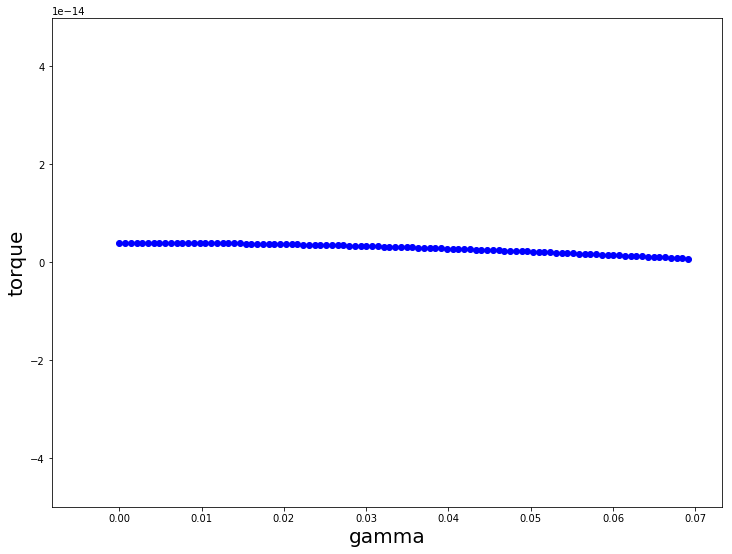

[0.0, 0.00069813170079773186, 0.0013962634015954637, 0.0020943951023931957, 0.0027925268031909274, 0.0034906585039886592, 0.0041887902047863914, 0.0048869219055841231, 0.0055850536063818549, 0.0062831853071795866, 0.0069813170079773184, 0.0076794487087750501, 0.0083775804095727827, 0.0090757121103705145, 0.0097738438111682462, 0.010471975511965978, 0.01117010721276371, 0.011868238913561441, 0.012566370614359173, 0.013264502315156905, 0.013962634015954637, 0.014660765716752368, 0.0153588974175501, 0.016057029118347832, 0.016755160819145565, 0.017453292519943295, 0.018151424220741029, 0.018849555921538759, 0.019547687622336492, 0.020245819323134222, 0.020943951023931956, 0.021642082724729686, 0.022340214425527419, 0.023038346126325153, 0.023736477827122883, 0.024434609527920616, 0.025132741228718346, 0.02583087292951608, 0.02652900463031381, 0.027227136331111543, 0.027925268031909273, 0.028623399732707007, 0.029321531433504737, 0.03001966313430247, 0.0307177948351002, 0.03141592653589793

In [27]:
"""Main function"""
time = 0
step = math.pi*(360/n)/180 #angle between each QD, angle required for one step
angle_increment = step/100
PCs = permanent_charges( Rp, p , cap_d, cap_vol, w, r) #initializes permanent charges

"""Graph of torque function to be approximated"""
fig = plt.figure(figsize=(12, 9))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('gamma', fontsize = '20')
ax1.set_ylabel('torque', fontsize = '20')
ax1.set_ylim(-0.5e-13 , 0.5e-13)

"""Computation of 'true' torque """
i = 0
T = []
gamma_list = []

fff = 1 #step/fff defines fraction of a step that motor travels before the charges move across
counter = 0

if fff > 0:
    X = step/fff
else:
    X = step

print X, step


for inc in np.arange(0, step+X, X):
    #print inc
    while counter < fff:
        for gamma in np.arange(inc, inc + X, angle_increment): #iterates angle increment until one step is completed
            gamma_list.append( gamma )
            F_t = tangential_component(k , n, e, R, Rp, gamma, noc, w, r, counter)
            T.append( torque(F_t, Rp, p, r) ) #calculates torque acting on inner rotor
            ax1.scatter(gamma, T[i] , color = 'b') #plots torque vs angle rotated
            i += 1 #needed to keep track of T array
        counter += 1
    
plt.show()
print gamma_list

In [13]:
counter = 1
QDs = quantum_dots( n, e, noc, counter)
print QDs[0][3]

-9.61305972e-19
